<a href="https://colab.research.google.com/github/GurgenGulay/Health_Risk/blob/main/Health_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import csv

pd.set_option('expand_frame_repr', True)
pd.set_option("display.max_rows", 999)
pd.set_option('max_colwidth', 100)

In [ ]:
file_path = '/content/Maternal Health Risk Data Set.csv'
df = pd.read_csv(file_path)
df.head

<bound method NDFrame.head of       Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0      25         130           80  15.0      98.0         86          1
1      35         140           90  13.0      98.0         70          1
2      29          90           70   8.0     100.0         80          1
3      30         140           85   7.0      98.0         70          1
4      35         120           60   6.1      98.0         76          0
...   ...         ...          ...   ...       ...        ...        ...
1009   22         120           60  15.0      98.0         80          1
1010   55         120           90  18.0      98.0         60          1
1011   35          85           60  19.0      98.0         86          1
1012   43         120           90  18.0      98.0         70          1
1013   32         120           65   6.0     101.0         76          0

[1014 rows x 7 columns]>

# Keşifci Veri Analizi
*   risk level ----> 1 = riskli, 0 = riskli değil


           

In [ ]:
def checkDf(dataframe, head=8):
    print("##### Shape #####")
    print(dataframe.shape)
    print("\n##### Types #####")
    print(dataframe.dtypes)
    print("\n##### Tail #####")  # sondan 8 indexi göster
    print(dataframe.tail(head))
    print("\n##### Head #####")  # baştan 8 indexi göster
    print(dataframe.head(head))
    print("\n##### Null Analysis #####")  # null değerlerin sayısı
    print(dataframe.isnull().sum())
    print("\n##### Quantiles #####")  # istatistikler (sayı, ortalama, ...)
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


checkDf(df)

df.columns = [col.upper() for col in df.columns]  # değişen isimlerini büyük harf yaptık

##### Shape #####
(1014, 7)

##### Types #####
Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel        int64
dtype: object

##### Tail #####
      Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
1006   17          85           60   6.3     102.0         86          1
1007   40         120           75   7.7      98.0         70          1
1008   48         120           80  11.0      98.0         88          1
1009   22         120           60  15.0      98.0         80          1
1010   55         120           90  18.0      98.0         60          1
1011   35          85           60  19.0      98.0         86          1
1012   43         120           90  18.0      98.0         70          1
1013   32         120           65   6.0     101.0         76          0

##### Head #####
   Age  SystolicBP  DiastolicBP     BS  BodyTemp  HeartRate  RiskLevel
0   25        

In [ ]:
def grabColNames(dataframe, catTh=10, carTh=20):
    # catCols, catButCar
    catCols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    numButCat = [col for col in dataframe.columns if dataframe[col].nunique() < catTh and
                 dataframe[col].dtypes != "O"]
    catButCar = [col for col in dataframe.columns if dataframe[col].nunique() > carTh and
                 dataframe[col].dtypes == "O"]
    catCols = catCols + numButCat
    catCols = [col for col in catCols if col not in catButCar]

    # numCols
    numCols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numCols = [col for col in numCols if col not in numButCat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'catCols: {len(catCols)}')
    print(f'numCols: {len(numCols)}')
    print(f'catButCar: {len(catButCar)}')
    print(f'numButCat: {len(numButCat)}')
    return catCols, numCols, catButCar


catCols, numCols, catButCar = grabColNames(df)

Observations: 1014
Variables: 7
catCols: 2
numCols: 5
catButCar: 0
numButCat: 2


In [ ]:
# Numerik ve kategorik değişkenlerin analizi

def catSummary(dataframe, colName, plot=False):
    print(pd.DataFrame({colName: dataframe[colName].value_counts(),
                        "Ratio": 100 * dataframe[colName].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[colName], data=dataframe)
        plt.show(block=True)


catSummary(df, "RISKLEVEL")

   RISKLEVEL      Ratio
0        576  56.804734
1        438  43.195266
##########################################


AGE:
count    1014.000000
mean       29.871795
std        13.474386
min        10.000000
5%         13.650000
10%        15.000000
20%        18.000000
30%        21.000000
40%        23.000000
50%        26.000000
60%        30.000000
70%        35.000000
80%        42.000000
90%        50.000000
95%        55.000000
99%        60.000000
100%       70.000000
max        70.000000
Name: AGE, dtype: float64


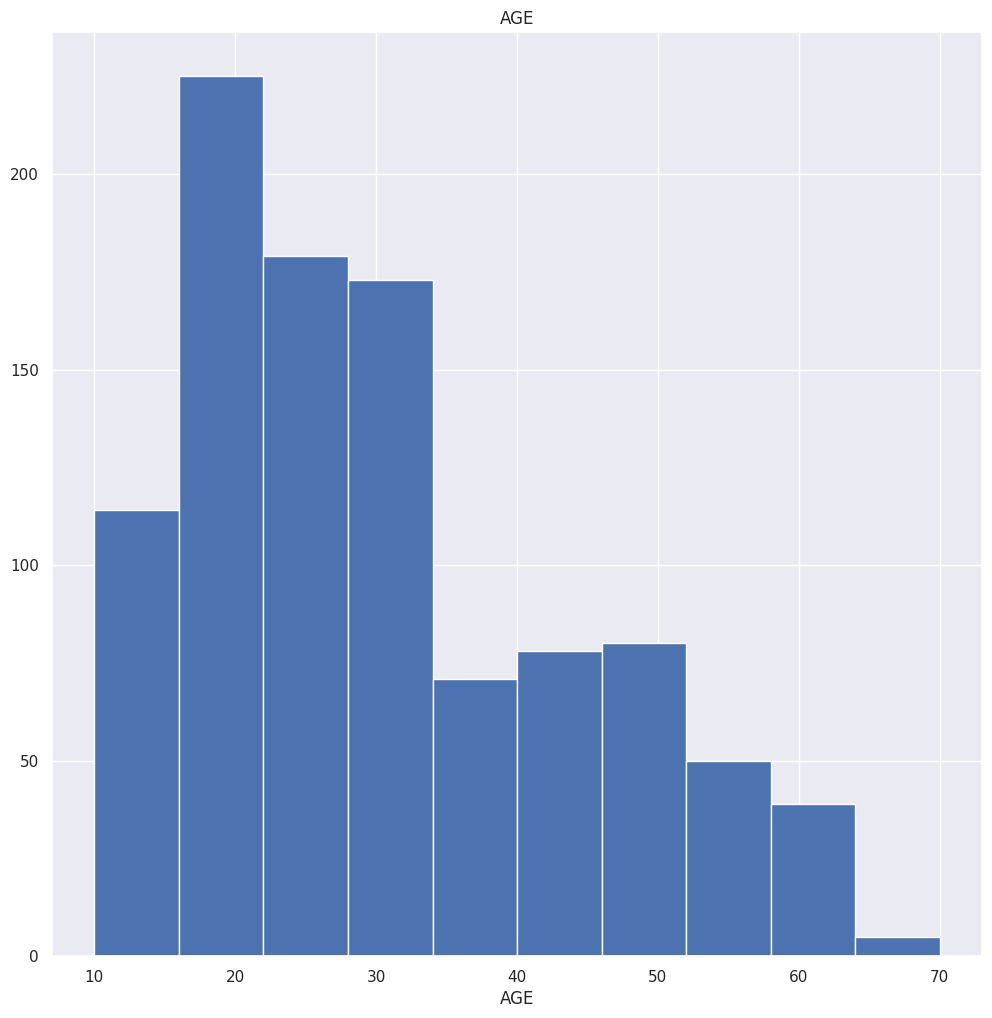

SYSTOLICBP:
count    1014.000000
mean      113.198225
std        18.403913
min        70.000000
5%         85.000000
10%        90.000000
20%        90.000000
30%       100.000000
40%       120.000000
50%       120.000000
60%       120.000000
70%       120.000000
80%       120.000000
90%       140.000000
95%       140.000000
99%       140.000000
100%      160.000000
max       160.000000
Name: SYSTOLICBP, dtype: float64


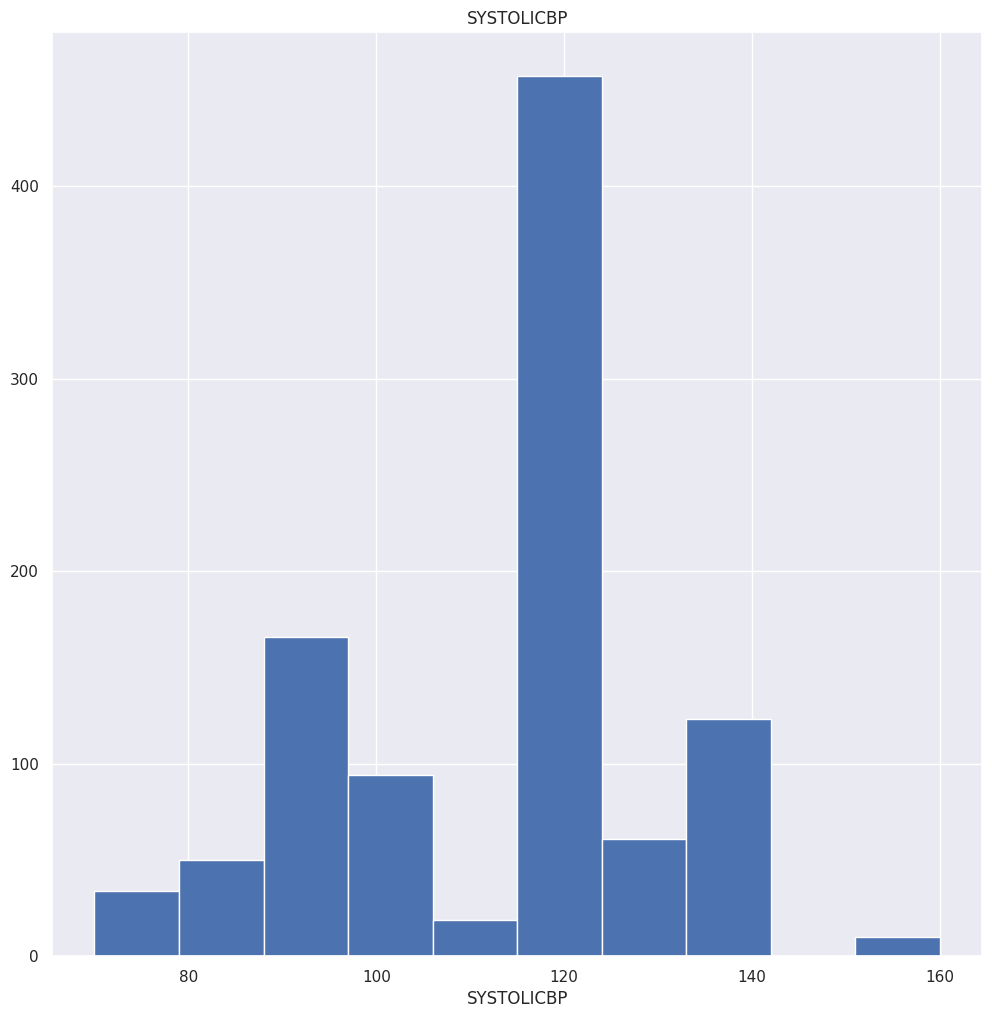

DIASTOLICBP:
count    1014.000000
mean       76.460552
std        13.885796
min        49.000000
5%         60.000000
10%        60.000000
20%        60.000000
30%        65.000000
40%        70.000000
50%        80.000000
60%        80.000000
70%        85.000000
80%        90.000000
90%        95.000000
95%       100.000000
99%       100.000000
100%      100.000000
max       100.000000
Name: DIASTOLICBP, dtype: float64


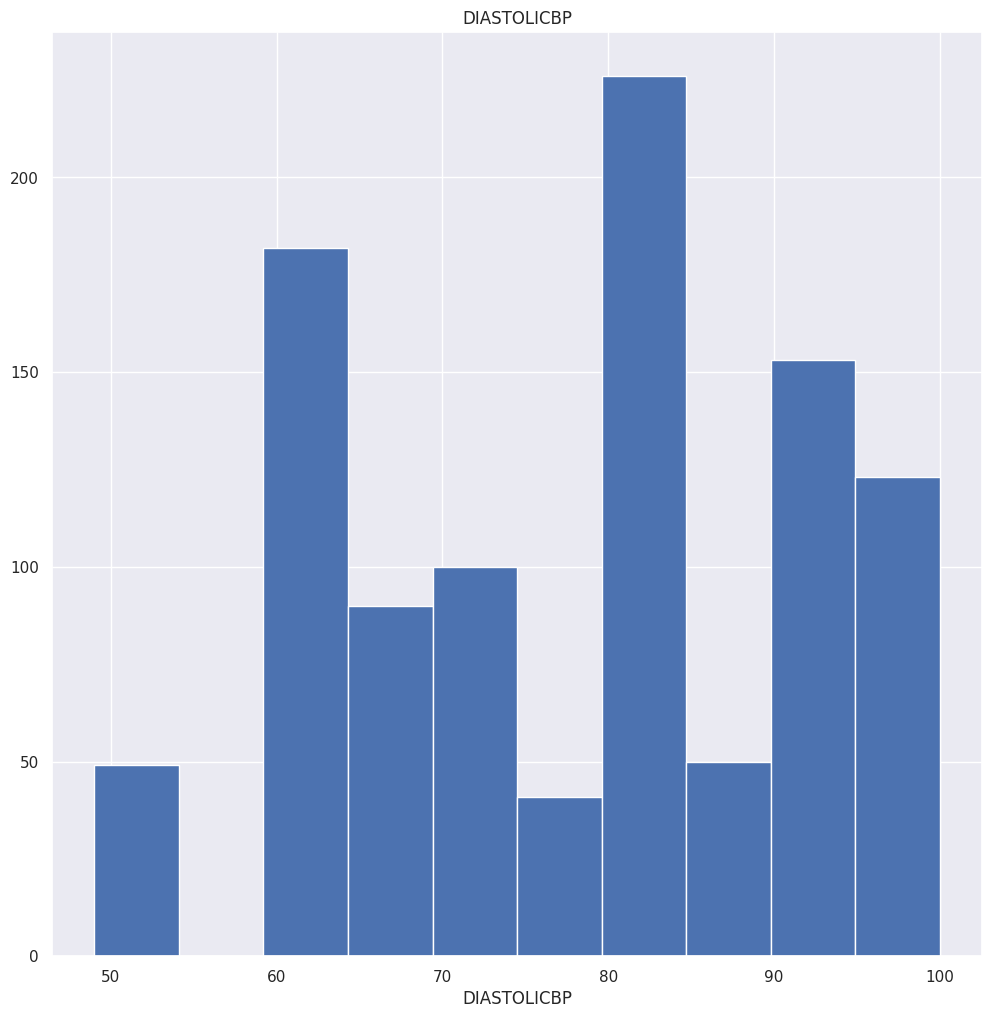

BS:
count    1014.000000
mean        8.725986
std         3.293532
min         6.000000
5%          6.100000
10%         6.700000
20%         6.800000
30%         6.900000
40%         7.010000
50%         7.500000
60%         7.500000
70%         7.900000
80%        11.000000
90%        15.000000
95%        17.350000
99%        19.000000
100%       19.000000
max        19.000000
Name: BS, dtype: float64


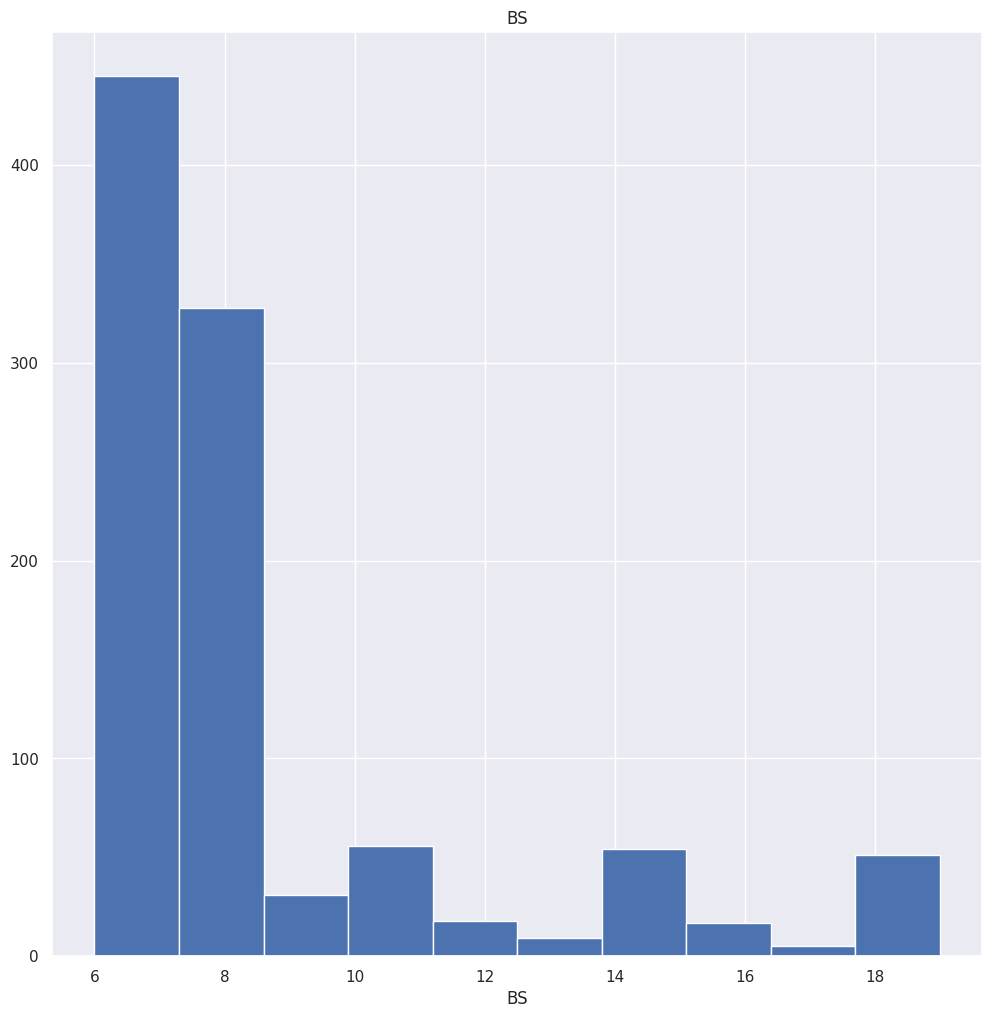

HEARTRATE:
count    1014.000000
mean       74.301775
std         8.088702
min         7.000000
5%         60.000000
10%        66.000000
20%        70.000000
30%        70.000000
40%        70.000000
50%        76.000000
60%        77.000000
70%        78.000000
80%        80.000000
90%        86.000000
95%        88.000000
99%        90.000000
100%       90.000000
max        90.000000
Name: HEARTRATE, dtype: float64


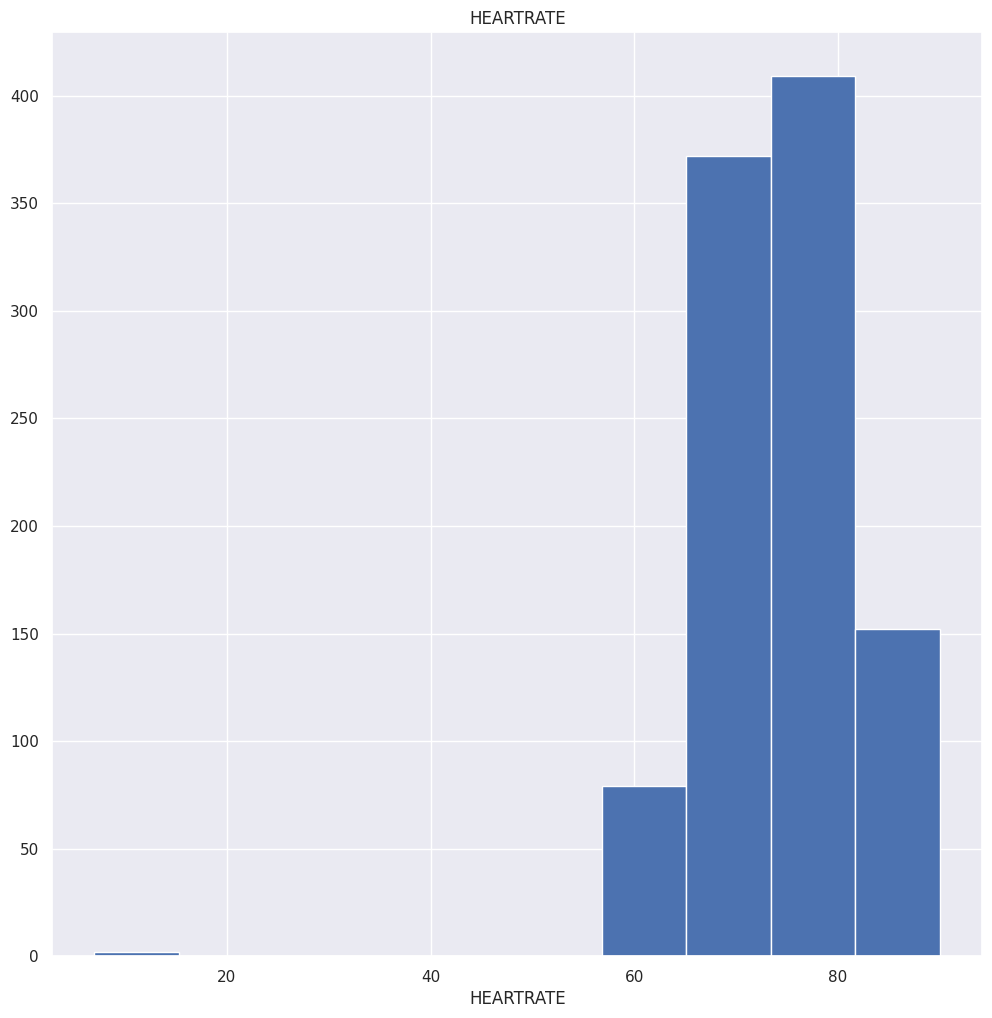

In [ ]:
def numSummary(dataframe, numericalCol, plot=False):
    quantiles = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    print(dataframe[numericalCol].describe(quantiles).T)

    if plot:
        dataframe[numericalCol].hist()
        plt.xlabel(numericalCol)
        plt.title(numericalCol)
        plt.show(block=True)


for col in numCols:
    print(f"{col}:")
    numSummary(df, col, True)


In [ ]:
# Hedef değişken analizi
def targetSummaryWithNum(dataframe, target, numCol):
    print(dataframe.groupby(target).agg({numCol: "mean"}), end="\n\n\n")


for col in numCols:
    targetSummaryWithNum(df, 'RISKLEVEL', col)

df.corr()

                 AGE
RISKLEVEL           
0          27.520833
1          32.963470


           SYSTOLICBP
RISKLEVEL            
0          107.833333
1          120.253425


           DIASTOLICBP
RISKLEVEL             
0            73.005208
1            81.004566


                  BS
RISKLEVEL           
0           7.414149
1          10.451142


           HEARTRATE
RISKLEVEL           
0          73.248264
1          75.687215




,AGE,SYSTOLICBP,DIASTOLICBP,BS,BODYTEMP,HEARTRATE,RISKLEVEL
AGE,1.000000,0.416045,0.398026,0.473284,-0.255323,0.079798,0.200182
SYSTOLICBP,0.416045,1.000000,0.787006,0.425172,-0.286616,-0.023108,0.334456
DIASTOLICBP,0.398026,0.787006,1.000000,0.423824,-0.257538,-0.046151,0.285502
BS,0.473284,0.425172,0.423824,1.000000,-0.103493,0.142867,0.456990
BODYTEMP,-0.255323,-0.286616,-0.257538,-0.103493,1.000000,0.098771,0.107906
HEARTRATE,0.079798,-0.023108,-0.046151,0.142867,0.098771,1.000000,0.149434
RISKLEVEL,0.200182,0.334456,0.285502,0.456990,0.107906,0.149434,1.000000


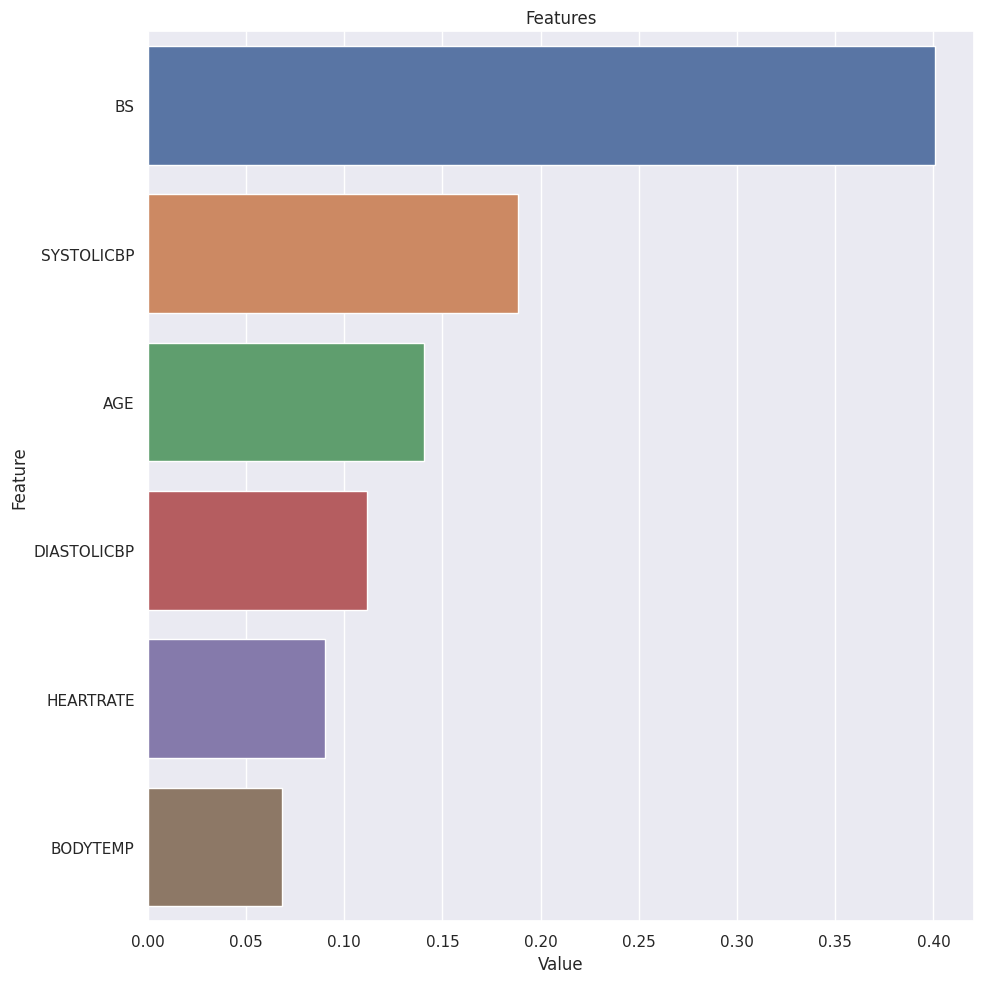

<Figure size 1200x1200 with 0 Axes>

In [ ]:
y = df["RISKLEVEL"]
X = df.drop("RISKLEVEL", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# bulduğumuz oranları grafiğe dökdük
def plot_importance(model, features, num=len(X), save=True):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('plot_importance.png')


plot_importance(rf_model, X)

In [ ]:
# Aykırı gözlem analizi

def outlierThresholds(dataframe, colName, q1=0.25, q3=0.75):
    quartile1 = dataframe[colName].quantile(q1)
    quartile3 = dataframe[colName].quantile(q3)
    interquantileRange = quartile3 - quartile1
    upLimit = quartile3 + 1.5 * interquantileRange
    lowLimit = quartile1 - 1.5 * interquantileRange
    return lowLimit, upLimit


def checkOutlier(dataframe, colName):
    lowLimit, upLimit = outlierThresholds(dataframe, colName)
    if dataframe[(dataframe[colName] > upLimit) | (dataframe[colName] < lowLimit)].any(axis=None):
        return True
    else:
        return False


for col in numCols:
    print(col, "-->", checkOutlier(df, col))

AGE --> True
SYSTOLICBP --> True
DIASTOLICBP --> False
BS --> True
HEARTRATE --> True



*   AGE --> True  dikkate alınmadı
*   SYSTOLICBP --> True
*   DIASTOLICBP --> False
*   BS --> True
*   HEARTRATE --> True  dikkate alınmadı

In [ ]:
def grabOutliers(dataframe, colName, index=False):
    low, up = outlierThresholds(dataframe, colName)
    outliers = dataframe[((dataframe[colName] < low) | (dataframe[colName] > up))]

    if outliers.shape[0] > 10:
        print(f"Aykırı Değerler for {colName}:\n{outliers.head()}")
    else:
        print(f"Aykırı Değerler for {colName}:\n{outliers}")

    if index:
        outlier_index = outliers.index
        return outlier_index


selected_cols = ['SYSTOLICBP', 'BS']
for col in selected_cols:
    print(col, grabOutliers(df, col, True))

Aykırı Değerler for SYSTOLICBP:
     AGE  SYSTOLICBP  DIASTOLICBP    BS  BODYTEMP  HEARTRATE  RISKLEVEL
123   40         160          100  19.0      98.0         77          1
130   40         160          100  19.0      98.0         77          1
166   40         160          100  19.0      98.0         77          1
262   40         160          100  19.0      98.0         77          1
362   40         160          100  19.0      98.0         77          1
538   40         160          100  19.0      98.0         77          1
583   40         160          100  19.0      98.0         77          1
689   40         160          100  19.0      98.0         77          1
961   40         160          100  19.0      98.0         77          1
994   40         160          100  19.0      98.0         77          1
SYSTOLICBP Int64Index([123, 130, 166, 262, 362, 538, 583, 689, 961, 994], dtype='int64')
Aykırı Değerler for BS:
    AGE  SYSTOLICBP  DIASTOLICBP    BS  BODYTEMP  HEARTRATE  RI

BS ve SYSTOLICBP aykırı değer olarak işaretlenen değerler incelendiğinde yanlış girdiğiye sahip olmadığı anlaşılıp,
aykırı olarak tanımlanmama kararı verilmiştir.

In [ ]:
# Eksik gözlem analizi
def missingValuesTable(dataframe, naName=False):
    naColums = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    nMiss = dataframe[naColums].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[naColums].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missingDf = pd.concat([nMiss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missingDf, end='\n')
    if naName:
        return naColums


missingValuesTable(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


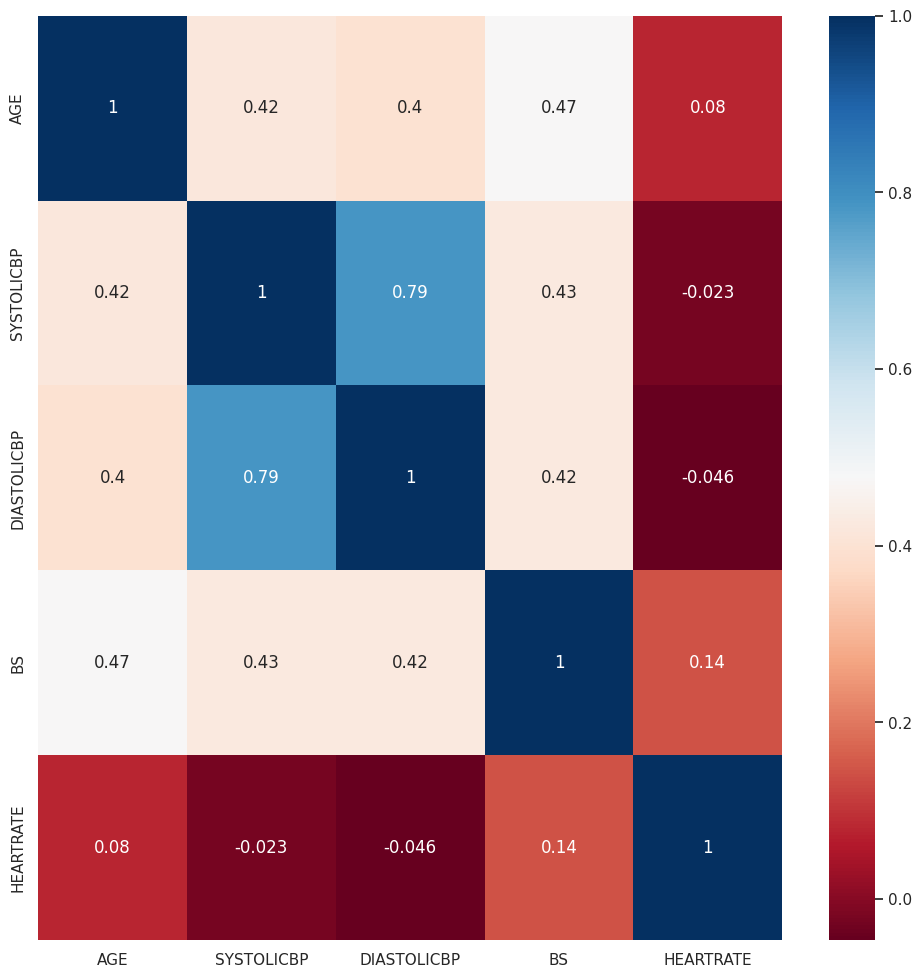

In [ ]:
#Korelasyon analizi
corr = df[numCols].corr()
corr

sns.set(rc={"figure.figsize": (12, 12)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

## Yeni değişkenlerin oluşturulması.



In [ ]:
# düşük, normal ve yüksek sıcaklık
df["BODY_TEMP_RANGES"] = ""
df.loc[(df["BODYTEMP"] <= 98.6), "BODY_TEMP_RANGES"] = "Low"
df.loc[((df["BODYTEMP"] > 98.6) & (df["BODYTEMP"] < 102)), "BODY_TEMP_RANGES"] = "Mid"
df.loc[(df["BODYTEMP"] >= 102), "BODY_TEMP_RANGES"] = "High"

In [ ]:
# kalp atış hızı risk düzeyi ( "Elevated" ,normal aralıkta olmayan ancak yüksek risk aralığında da bulunmayan ve "Increased" normal aralıkta olmayan ve yüksek risk aralığında bulunan)
df["HEARTRATE_RANGES"] = ""
df.loc[((df["HEARTRATE"] >= 75) & (df["HEARTRATE"] <= 80)), "HEARTRATE_RANGES"] = "Normal"
df.loc[((df["HEARTRATE"] > 80) & (df["HEARTRATE"] < 90)), "HEARTRATE_RANGES"] = "Elevated"
df.loc[((df["HEARTRATE"] >= 90) & (df["HEARTRATE"] <= 140)), "HEARTRATE_RANGES"] = "Increased"
df.loc[(df["HEARTRATE"] > 140), "HEARTRATE_RANGES"] = "High"


In [ ]:
# Kan Basıncı risk düzeyi
df["BloodPressure_RANGES"] = ""
df.loc[((df["SYSTOLICBP"] >= 120) & (df["SYSTOLICBP"] <= 139) & (df["DIASTOLICBP"] >= 80) & (df["DIASTOLICBP"] <= 89)),
       "BloodPressure_RANGES"] = "Low"
df.loc[((df["SYSTOLICBP"] >= 140) & (df["SYSTOLICBP"] <= 159) & (df["DIASTOLICBP"] >= 90) & (df["DIASTOLICBP"] <= 99)),
       "BloodPressure_RANGES"] = "Mid"
df.loc[((df['SYSTOLICBP'] >= 160) | (df["DIASTOLICBP"] >= 100)),
       "BloodPressure_RANGES"] = "High"

In [ ]:
# Kan şekeri risk düzeyi belirleme
df["BloodGlucose_RANGES"] = ""
df.loc[df["BS"] < 7.8, "BloodGlucose_RANGES"] = "Low"
df.loc[(df["BS"] >= 7.8) & (df['BS'] < 11.1), "BloodGlucose_RANGES"] = "Mid"
df.loc[df["BS"] >= 11.1, "BloodGlucose_RANGES"] = "High"

In [ ]:
# Yaş risk düzeyi belirleme
df["Age_RANGES"] = ""
df.loc[(df["AGE"] >= 20) & (df["AGE"] <= 29), 'Age_RANGES'] = "Low"
df.loc[(df["AGE"] > 29) & (df["AGE"] <= 35), 'Age_RANGES'] = "Mid"
df.loc[(df["AGE"] > 35), 'Age_RANGES'] = "High"

df.head()

,AGE,SYSTOLICBP,DIASTOLICBP,BS,BODYTEMP,HEARTRATE,RISKLEVEL,BODY_TEMP_RANGES,HEARTRATE_RANGES,BloodPressure_RANGES,BloodGlucose_RANGES,Age_RANGES
0,25,130,80,15.0,98.0,86,1,Low,Elevated,Low,High,Low
1,35,140,90,13.0,98.0,70,1,Low,,Mid,High,Mid
2,29,90,70,8.0,100.0,80,1,Mid,Normal,,Mid,Low
3,30,140,85,7.0,98.0,70,1,Low,,,Low,Mid
4,35,120,60,6.1,98.0,76,0,Low,Normal,,Low,Mid


## Encoding




In [ ]:
def labelEncoder(dataframe, binaryCol):
    labelencoder = LabelEncoder()
    dataframe[binaryCol] = labelencoder.fit_transform(dataframe[binaryCol])
    return dataframe


binaryCols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
binaryCols

for col in binaryCols:
    labelEncoder(df, col)


In [ ]:
def rareAnalyzer(dataframe, target, catCols):
    for col in catCols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame(
            {"COUNT": dataframe[col].value_counts(), "RATIO": dataframe[col].value_counts() / len(dataframe),
             "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


rareAnalyzer(df, "RISKLEVEL", binaryCols)

In [ ]:
def rareEncoder(dataframe, rarePerc):
    tempDf = dataframe.copy()
    rare_columns = [col for col in tempDf.columns if
                    tempDf[col].dtypes == "O" and (tempDf[col].value_counts() / len(tempDf) < rarePerc).any(axis=None)]
    for var in rare_columns:
        tmp = tempDf[var].value_counts() / len(tempDf)
        rareLabels = tmp[tmp < rarePerc].index
        tempDf[var] = np.where(tempDf[var].isin(rareLabels), "Rare", tempDf[var])
    return tempDf


df = rareEncoder(df, 0.01)

In [ ]:
def oneHotEncoder(dataframe, categoricalCols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categoricalCols, drop_first=drop_first)
    return dataframe


oheCols = [col for col in df.columns if (10 >= df[col].nunique() > 2) and (col != "RISKLEVEL")]
df = oneHotEncoder(df, oheCols)

In [ ]:
# Numerik değişkenler için standartlaştırma
scaler = StandardScaler()
df[numCols] = scaler.fit_transform(df[numCols])
df[numCols].head()

df.columns
df.head()

,AGE,SYSTOLICBP,DIASTOLICBP,BS,HEARTRATE,RISKLEVEL,BODYTEMP_98.0,BODYTEMP_98.4,BODYTEMP_98.6,BODYTEMP_99.0,BODYTEMP_100.0,BODYTEMP_101.0,BODYTEMP_102.0,BODYTEMP_103.0,BODY_TEMP_RANGES_High,BODY_TEMP_RANGES_Low,BODY_TEMP_RANGES_Mid,HEARTRATE_RANGES_,HEARTRATE_RANGES_Elevated,HEARTRATE_RANGES_Increased,HEARTRATE_RANGES_Normal,BloodPressure_RANGES_,BloodPressure_RANGES_High,BloodPressure_RANGES_Low,BloodPressure_RANGES_Mid,BloodGlucose_RANGES_High,BloodGlucose_RANGES_Low,BloodGlucose_RANGES_Mid,Age_RANGES_,Age_RANGES_High,Age_RANGES_Low,Age_RANGES_Mid
0,-0.361738,0.913396,0.255023,1.905890,1.446956,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
1,0.380777,1.457027,0.975539,1.298340,-0.532088,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1
2,-0.064732,-1.261127,-0.465493,-0.220537,0.704815,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0
3,0.009519,1.457027,0.615281,-0.524312,-0.532088,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,0.380777,0.369765,-1.186009,-0.797710,0.210054,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1


# kNN Algoritması

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [ ]:
y = df["RISKLEVEL"]
X = df.drop(["RISKLEVEL"], axis=1)

X_scaled = StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

knn_model = KNeighborsClassifier().fit(X, y)

In [ ]:
random_user = X.sample(1, random_state=45)

knn_model.predict(random_user)

array([1])

Hyperparameter Optimization

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.get_params()

knn_params = {"n_neighbors": range(2, 50)}
knn_gs_best = GridSearchCV(knn_model,
                           knn_params,
                           cv=5,
                           n_jobs=-1,
                           verbose=1).fit(X, y)

knn_gs_best.best_params_
# {'n_neighbors': 41}

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'n_neighbors': 41}

In [ ]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X, y)  # bulduğumuz en iyi komşuluk değerini set ediyoruz. ** ile otomatik atama yapılır.

cv_results = cross_validate(knn_final,
                            X,
                            y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.7633029312783496

In [ ]:
y_pred = knn_final.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.93      0.82       576
           1       0.86      0.56      0.68       438

    accuracy                           0.77      1014
   macro avg       0.80      0.75      0.75      1014
weighted avg       0.79      0.77      0.76      1014



In [ ]:
y_probs = knn_model.predict_proba(X)
roc_auc_scores = roc_auc_score(pd.get_dummies(y), y_probs, multi_class="ovr")

print("Macro Average ROC AUC Score:", roc_auc_scores)

Macro Average ROC AUC Score: 0.8311790493404363


In [ ]:
conf_matrix = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

true_positive = conf_matrix[1, 1]
false_positive = conf_matrix[0, 1]
true_negative = conf_matrix[0, 0]
false_negative = conf_matrix[1, 0]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Confusion Matrix:
[[535  41]
 [191 247]]
Sensitivity: 0.5639269406392694
Specificity: 0.9288194444444444


In [ ]:
kappa = cohen_kappa_score(y, y_pred)
print(f"Cohen's Kappa: {kappa}")

Cohen's Kappa: 0.5138258562110953


# SVM Algoritması


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn import datasets, svm
from sklearn.svm import SVC
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
y = df["RISKLEVEL"]
X = df.drop(["RISKLEVEL"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [ ]:
svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
svm.fit(X_train, y_train)

print("train accuracy:",svm.score(X_train,y_train))
print("test accuracy:",svm.score(X_test,y_test))

train accuracy: 0.825
test accuracy: 0.7322834645669292


In [ ]:
y_pred = svm.predict(X_test)
print(y_pred)

[0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0
 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0
 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0]


In [ ]:
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

report=classification_report(y_test, svm.predict(X_test))
print("Classification Report:")

lines = report.split('\n')
for line in lines:
    print(line)

Accuracy: 73.23%
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       132
           1       0.85      0.54      0.66       122

    accuracy                           0.73       254
   macro avg       0.76      0.73      0.72       254
weighted avg       0.76      0.73      0.72       254



In [ ]:
from sklearn.preprocessing import label_binarize

y_scores = svm.decision_function(X_test)
y_test_bin = label_binarize(y_test, classes=svm.classes_)

auc_score = roc_auc_score(y_test_bin, y_scores, average='weighted', multi_class='ovr')
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.7908283656234476


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.5409836065573771
Specificity: 0.9090909090909091


In [ ]:
observed_accuracy = accuracy_score(y_test, y_pred)
expected_accuracy = ((TN + FP) * (TN + FN) + (FP + TP) * (FN + TP)) / (len(y_test) ** 2)
kappa = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)
print("Kappa:", kappa)

Kappa: 0.4563082347015866


# Karar Ağaçları Algoritması

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(random_state=122)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=122)

Xtrain = train.drop(columns=['RISKLEVEL'], axis=1)
ytrain = train['RISKLEVEL']

Xtest = test.drop(columns=['RISKLEVEL'], axis=1)
ytest = test['RISKLEVEL']

In [ ]:
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(Xtrain, ytrain)

print('Best Parameters: ', grid_search_tree.best_params_)
print('Best Accuracy: ', grid_search_tree.best_score_)

Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Best Accuracy:  0.7916003938498826


In [ ]:
best_tree = grid_search_tree.best_estimator_

test_accuracy = best_tree.score(Xtest, ytest)
print('Test Accuracy: ', test_accuracy)

Test Accuracy:  0.7980295566502463


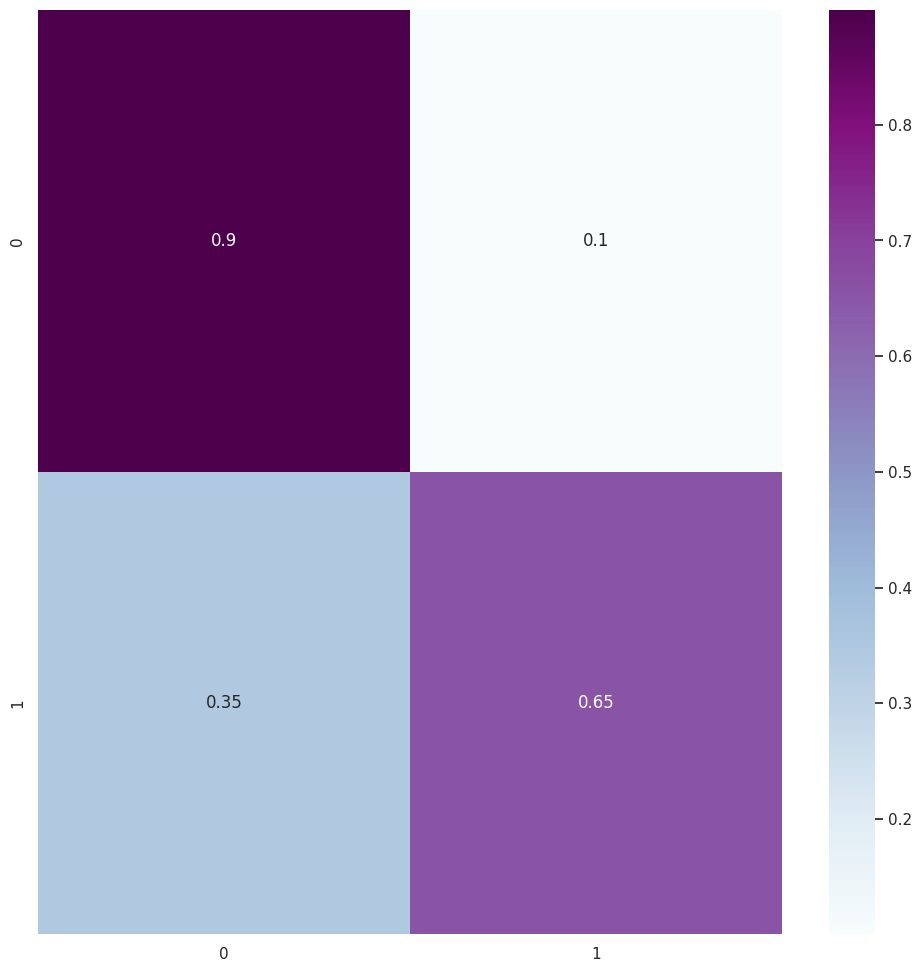

In [ ]:
from sklearn.metrics import confusion_matrix

ypred = best_tree.predict(Xtest)

labels = ytest.unique()

cm_tree = confusion_matrix(ytest, ypred, normalize='true')
plt.figure()
sns.heatmap(cm_tree, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.show()

In [ ]:
report = classification_report(ytest, ypred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       119
           1       0.82      0.65      0.73        84

    accuracy                           0.80       203
   macro avg       0.80      0.78      0.78       203
weighted avg       0.80      0.80      0.79       203



Test ROC AUC: 0.8445378151260505


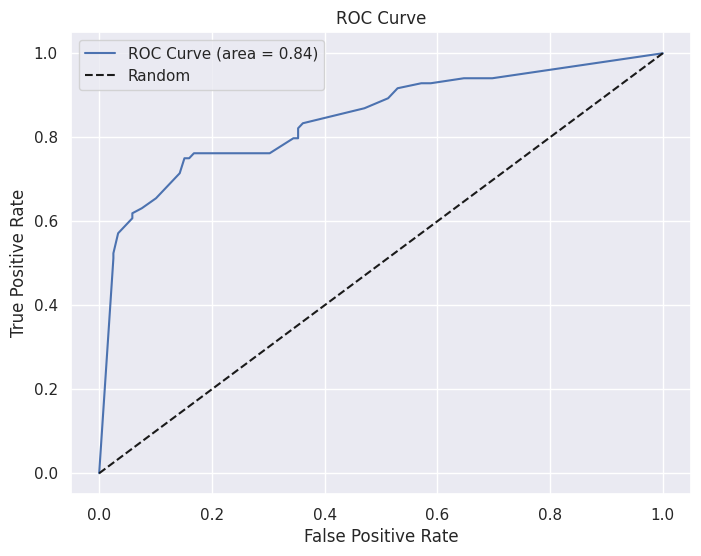

In [ ]:
ytest_pred_proba = best_tree.predict_proba(Xtest)[:, 1]

roc_auc_test = roc_auc_score(ytest, ytest_pred_proba)
fpr, tpr, _ = roc_curve(ytest, ytest_pred_proba)
print("Test ROC AUC:", roc_auc_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
conf_matrix = confusion_matrix(ytest, ypred)

TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("Specificity:", specificity)
print("Sensitivity:", sensitivity)


Specificity: 0.8991596638655462
Sensitivity: 0.6547619047619048


In [ ]:
observed_accuracy = (TP + TN) / (TP + TN + FP + FN)
expected_accuracy = ((TN + FP) * (TN + FN) + (FP + TP) * (FN + TP)) / ((TP + TN + FP + FN) ** 2)
kappa = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)
print("Kappa:", kappa)

Kappa: 0.5709130277878023


# Yapay Sinir Ağları ANN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


if y_train.dtype == 'O':
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
num_classes = len(set(y_train))

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=num_classes, activation='sigmoid'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
24/24 [==============================] - 1s 12ms/step - loss: 0.6642 - accuracy: 0.6053 - val_loss: 0.5424 - val_accuracy: 0.7638
Epoch 2/15
24/24 [==============================] - 0s 4ms/step - loss: 0.5150 - accuracy: 0.7750 - val_loss: 0.5079 - val_accuracy: 0.7638
Epoch 3/15
24/24 [==============================] - 0s 4ms/step - loss: 0.4870 - accuracy: 0.7816 - val_loss: 0.4988 - val_accuracy: 0.7717
Epoch 4/15
24/24 [==============================] - 0s 4ms/step - loss: 0.4746 - accuracy: 0.7882 - val_loss: 0.4950 - val_accuracy: 0.7677
Epoch 5/15
24/24 [==============================] - 0s 5ms/step - loss: 0.4618 - accuracy: 0.7934 - val_loss: 0.4954 - val_accuracy: 0.7717
Epoch 6/15
24/24 [==============================] - 0s 4ms/step - loss: 0.4530 - accuracy: 0.7987 - val_loss: 0.4938 - val_accuracy: 0.7638
Epoch 7/15
24/24 [==============================] - 0s 4ms/step - loss: 0.4483 - accuracy: 0.7987 - val_loss: 0.4944 - val_accuracy: 0.7717
Epoch 8/15
24/24 [=

In [ ]:
y_train_pred_proba = model.predict(X_train)
y_train_pred = (y_train_pred_proba > 0.5).astype(int)

24/24 [==============================] - 0s 3ms/step


In [ ]:
y_test_pred_proba = model.predict(X_test)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

8/8 [==============================] - 0s 3ms/step


In [ ]:
# Train accuracy
y_train_pred_proba = model.predict(X_train)
y_train_pred = y_train_pred_proba.argmax(axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Test accuracy
y_test_pred_proba = model.predict(X_test)
y_test_pred = y_test_pred_proba.argmax(axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

24/24 [==============================] - 0s 3ms/step
Train Accuracy: 0.8039473684210526
8/8 [==============================] - 0s 5ms/step
Test Accuracy: 0.7598425196850394


In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[132  15]
 [ 46  61]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       147
           1       0.80      0.57      0.67       107

    accuracy                           0.76       254
   macro avg       0.77      0.73      0.74       254
weighted avg       0.77      0.76      0.75       254



In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

Specificity: 0.8979591836734694
Sensitivity: 0.5700934579439252


In [ ]:
observed_accuracy = (TP + TN) / (TP + TN + FP + FN)
expected_accuracy = ((TN + FP) * (TN + FN) + (FP + TP) * (FN + TP)) / ((TP + TN + FP + FN) ** 2)
kappa = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)
print("Kappa:", kappa)

Kappa: 0.4872592494539678


In [ ]:
y_train_pred_proba = model.predict(X_train)
y_train_pred_proba = y_train_pred_proba[:, 1]

roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)


print("Train ROC AUC:", roc_auc_train)

24/24 [==============================] - 0s 3ms/step
Train ROC AUC: 0.867122303678195


In [ ]:
y_test_pred_proba = model.predict(X_test)
y_test_pred_proba = y_test_pred_proba[:, 1]

roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

print("Test ROC AUC:", roc_auc_test)

8/8 [==============================] - 0s 3ms/step
Test ROC AUC: 0.7973488460804883
